In [1]:
from mdp import MDP
import numpy as np

from mdp import has_graphviz
from mdp import plot_graph
from mdp import FrozenLakeEnv
from IPython.display import display
print("Graphviz available:", has_graphviz)

from time import time

Graphviz available: True


## Value iteration (VI)

In [2]:
def get_Q_sa(mdp: MDP, V, s, a, gamma):
    """
    Оценивает полезность действия a в состоянии s, если 
    полезности всех состояний - V.
    """
    assert a in mdp.get_possible_actions(s)

    Q = 0
    for s_new, p in mdp.get_next_states(s, a).items():
        r = mdp.get_reward(s, a, s_new)
        V_new = V[s_new]
        Q += p * (r + gamma * V_new)
    return Q

In [3]:
def get_new_V_s(mdp, V, s, gamma):
    """
    Вычисляет новую полезность состояния s в алгоритме VI,
    если полезности всех состояний равны V.
    """
    if mdp.is_terminal(s):
        return 0

    return np.max([
        get_Q_sa(mdp, V, s, a, gamma) 
        for a in mdp.get_possible_actions(s)
    ])


def get_new_V(mdp, V, gamma):
    """
    Вычисляет новую полезность всех состояний в алгоритме VI,
    если полезности всех состояний равны V.
    """
    return {
        s: get_new_V_s(mdp, V, s, gamma)
        for s in mdp.get_all_states()
    }

def get_V_diff(mdp, V1, V0):
    return max(abs(V1[s] - V0[s]) for s in mdp.get_all_states())

In [4]:
def value_iteration(
        mdp, gamma, V=None, 
        max_steps=1000, 
        min_diff=1e-5,
        ):
    """ 
    Делает num_iter шагов VI начиная с полезностей состояний V. 
    Прерывается, если последовательные V достаточно близки.
    """
    V = V or {s: 0 for s in mdp.get_all_states()}
    V_at_each_step = [V]

    for step in range(max_steps):
        new_V = get_new_V(mdp, V, gamma)
        V_at_each_step.append(new_V)

        diff = get_V_diff(mdp, new_V, V)
        V = new_V
        
        step += 1
        if diff < min_diff:
            break

    return V, V_at_each_step

In [5]:
def get_optimal_action(mdp, V, s, gamma):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(s):
        return None

    return max(
        mdp.get_possible_actions(s), 
        key=lambda a: get_Q_sa(mdp, V, s, a, gamma)
        )


def get_optimal_policy(mdp: MDP, V, gamma):
    return {
        s: get_optimal_action(mdp, V, s, gamma) 
        for s in mdp.get_all_states()
        }

def are_policies_equal(policy1, policy2):
    return set(policy1.items()) == set(policy2.items())

## MDP для которого VI долго сходится (1 pts)

In [6]:

def get_vi_breaking_mdp(gamma, N):
    """
    Возвращает MDP с 3 состояниями и 2 действиями,
    для которого VI начинает выдавать правильную стратегию
    лишь спустя N шагов, при дисконтировании награды gamma
    Возвращает построенный MDP и функцию полезности состояний для него.
    """

    transition_probs = {
        's0': {
            'a1': {'s1': 1},
            'a2': {'s2': 1}
        },
        's1': {'a1': {'s1': 1}},
        's2': {'a2': {'s2': 1}},
    }

    r = gamma*np.mean([1-gamma**(N-1), 1-gamma**N])/(1-gamma)
    rewards = {
        's0': {
            'a1': {'s1': 0},
            'a2': {'s2': r}
        },
        's1': {'a1': {'s1': 1}},
        's2': {'a2': {'s2': 0}},
    }

    V = {'s0': gamma/(1-gamma), 's1': 1/(1-gamma), 's2': 0}
    mdp = MDP(transition_probs, rewards, initial_state='s0')

    return mdp, V

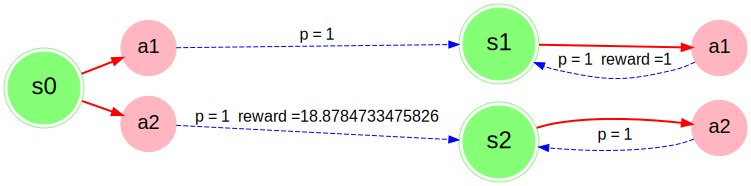

In [7]:
vi_breaking_gamma = 0.95
vi_breaking_mdp, _ = get_vi_breaking_mdp(gamma=0.95, N=99)
display(plot_graph(vi_breaking_mdp))

In [8]:
V_final, V_at_each_step = value_iteration(vi_breaking_mdp, vi_breaking_gamma)

In [9]:
policy = {s: None for s in vi_breaking_mdp.get_all_states() }

for i, V in enumerate(V_at_each_step):
    new_policy = get_optimal_policy(vi_breaking_mdp, V, vi_breaking_gamma)

    n_diff = len([
        s for s in vi_breaking_mdp.get_all_states() 
        if new_policy[s] != policy[s]
        ])
    
    if not are_policies_equal(new_policy, policy) > 0:
        print(f'{i:4}  policy={new_policy}')
    
    policy = new_policy


   0  policy={'s0': 'a2', 's1': 'a1', 's2': 'a2'}
  99  policy={'s0': 'a1', 's1': 'a1', 's2': 'a2'}


## Policy iteration (PI) - 3 pts

In [10]:
def compute_V(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    all_states = mdp.get_all_states()
    idx = {s: idx for idx, s in enumerate(sorted(all_states))}
    idx2state = {idx: s for idx, s in enumerate(sorted(all_states))}
    S = len(idx)
    R = np.zeros(shape=S)
    P = np.zeros(shape=(S, S))
    for s in all_states:
        if mdp.is_terminal(s):
            continue
        a = policy[s]
        for next_s, p in mdp.get_next_states(s, a).items():  
            P[idx[s]][idx[next_s]] = p
            R[idx[s]] += p * mdp.get_reward(s, a, next_s)

    R = R.reshape((S, 1))
    V = np.linalg.inv(np.eye(S) - gamma*P) @ R
    assert V.shape == (S, 1)

    V = V.reshape(S)
    return {idx2state[idx]: V[idx] for idx in range(S)}

In [11]:
def get_random_action(mdp, s):
    acts = mdp.get_possible_actions(s)
    if len(acts) == 0:
        return None
    return np.random.choice(acts)


def get_random_policy(mdp):
    return {
        s: get_random_action(mdp, s)
        for s in mdp.get_all_states()
    }

In [12]:
def policy_iteration(
        mdp, gamma, policy=None, 
        max_steps=1000
        ):  
    policy = policy or get_random_policy(mdp)   
    all_policies_and_V = []

    for i in range(max_steps):
        V = compute_V(mdp, policy, gamma)
        all_policies_and_V.append((policy, V))

        new_policy = get_optimal_policy(mdp, V, gamma)
        if are_policies_equal(new_policy, policy):
            break

        policy = new_policy

    return policy, V, all_policies_and_V

In [13]:
test_pi_mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.5)
test_pi_gamma = 0.95
policy, V, all_policies_and_V = policy_iteration(test_pi_mdp, test_pi_gamma)

In [14]:
print(len(all_policies_and_V))

7


## Сравнение VI и PI

In [15]:
test_cases = [
    ('vi_breaking_mdp', vi_breaking_mdp, vi_breaking_gamma),
    ('FrozenLake 4x4, slip_chance=0.2', 
        FrozenLakeEnv(map_name='4x4', slip_chance=0.2), 0.9),
    ('FrozenLake 8x8, slip_chance=0.2', 
        FrozenLakeEnv(map_name='8x8', slip_chance=0.2), 0.9), 
]


N = 100

for name, mdp, gamma in test_cases:
    optimal_policy, optimal_V, _ = policy_iteration(mdp, gamma)

    times_vi = []
    for _ in range(N):
        t0 = time()
        V, _ = value_iteration(mdp, gamma)
        times_vi.append(time() - t0)
        
        policy = get_optimal_policy(mdp, V, gamma)
        assert are_policies_equal(optimal_policy, policy)

    times_pi = []
    for _ in range(N):
        t0 = time()
        policy, V, _ = policy_iteration(mdp, gamma)
        times_pi.append(time() - t0)

        assert are_policies_equal(optimal_policy, policy)

    print(f'{name}:')
    print(f'  VI time = {np.mean(times_vi)}+-{np.std(times_vi)}')
    print(f'  PI time = {np.mean(times_pi)}+-{np.std(times_pi)}')

vi_breaking_mdp:
  VI time = 0.02216921329498291+-0.004722466023039892
  PI time = 0.0008510541915893555+-0.002280837571433603
FrozenLake 4x4, slip_chance=0.2:
  VI time = 0.01705634593963623+-0.00419952867966967
  PI time = 0.004777874946594238+-0.0016434791719563443
FrozenLake 8x8, slip_chance=0.2:
  VI time = 0.11121118068695068+-0.015305721708707256
  PI time = 0.04302286863327026+-0.00973593614075259
